In [1]:
import os
import re
from typing import List, Dict, Optional, Union
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings


class SmartPDFProcessor:
    """
    Production-grade multi-PDF Processor for Retrieval-Augmented Generation (RAG).
    - Uses hybrid chunking for better course outlines & regulations capture.
    - Enhances metadata (course_code, program, section_type) during ingestion.
    """

    OUTLINE_KEYWORDS = ["outline", "course content", "course outline", "syllabus", "topics covered"]
    COURSE_CODE_PATTERN = r"(COMP\s*\d+|CS\s*\d+|SE\s*\d+)"
    PROGRAM_IDENTIFIERS = {"MS": ["MS", "Master", "Graduate"], "BS": ["BS", "Bachelor", "Undergraduate"]}

    def __init__(
        self,
        model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
        min_char_threshold: int = 50,
        recursive: bool = True,
        min_chunk_size: int = 1200,  # best for outlines
        ):
        self.embedding_model = HuggingFaceEmbeddings(model_name=model_name)
        self.text_splitter = SemanticChunker(
        self.embedding_model,
        breakpoint_threshold_type="percentile",
        min_chunk_size=min_chunk_size
    )
        self.min_char_threshold = min_char_threshold
        self.recursive = recursive


    def process_directory(
        self,
        directory_path: str,
        custom_metadata: Optional[Dict[str, Union[str, int]]] = None
    ) -> List[Document]:
        """Process all PDFs in a directory and return chunks."""
        all_chunks = []
        pdf_files = self._get_pdf_files(directory_path)

        for pdf_path in pdf_files:
            print(f"📄 Processing: {pdf_path}")
            chunks = self._process_single_pdf(pdf_path, custom_metadata)
            all_chunks.extend(chunks)

        print(f"✅ Completed processing {len(pdf_files)} PDFs. Total chunks created: {len(all_chunks)}")
        return all_chunks

    def _get_pdf_files(self, directory_path: str) -> List[str]:
        """Return list of PDF file paths from directory."""
        pdf_files = []
        for root, _, files in os.walk(directory_path):
            for file in files:
                if file.lower().endswith(".pdf"):
                    pdf_files.append(os.path.join(root, file))
            if not self.recursive:
                break
        return pdf_files

    def _extract_metadata_from_text(self, text: str) -> Dict[str, Union[str, int]]:
        """Extract course code, program type, outline sections based on patterns."""
        metadata = {}

        # Extract Course Code
        match = re.search(self.COURSE_CODE_PATTERN, text, re.IGNORECASE)
        if match:
            metadata["course_code"] = match.group(0).replace(" ", "").upper()

        # Detect Program Type
        for program, keywords in self.PROGRAM_IDENTIFIERS.items():
            if any(k.lower() in text.lower() for k in keywords):
                metadata["program"] = program

        # Section Detection
        if any(keyword in text.lower() for keyword in self.OUTLINE_KEYWORDS):
            metadata["section_type"] = "course_outline"
        elif any(word in text.lower() for word in ["credit", "hours", "structure"]):
            metadata["section_type"] = "course_structure"
        else:
            metadata["section_type"] = "general"

        return metadata

    def _process_single_pdf(
        self, pdf_path: str, custom_metadata: Optional[Dict[str, Union[str, int]]] = None
    ) -> List[Document]:
        """Private method to process a single PDF with semantic chunking and metadata enrichment."""
        try:
            loader = PyPDFLoader(pdf_path)
            pages = loader.load()
        except Exception as e:
            print(f"❌ Error loading PDF {pdf_path}: {e}")
            return []

        processed_chunks = []

        for page_num, page in enumerate(pages):
            cleaned_text = self._clean_text(page.page_content)

            if len(cleaned_text.strip()) < self.min_char_threshold:
                continue

            metadata = {
                "source_file": os.path.basename(pdf_path),
                "source_path": pdf_path,
                "page": page_num + 1,
                "total_pages": len(pages),
                "char_count": len(cleaned_text),
            }

            # Merge extracted metadata
            extracted_meta = self._extract_metadata_from_text(cleaned_text)
            metadata.update(extracted_meta)

            if page.metadata:
                metadata.update(page.metadata)
            if custom_metadata:
                metadata.update(custom_metadata)

            try:
                chunks = self.text_splitter.create_documents(
                    texts=[cleaned_text],
                    metadatas=[metadata]
                )
                processed_chunks.extend(chunks)
            except Exception as e:
                print(f"⚠️ Chunking failed on file {pdf_path}, page {page_num+1}: {e}")

        return processed_chunks

    def _clean_text(self, text: str) -> str:
        """Advanced PDF text cleaning preserving structure for outlines."""
        # Preserve numbered/bulleted lists (convert to newline format)
        text = re.sub(r'(?<!\n)(\d+\.\s)', r'\n\1', text)  # Numbered lists
        text = re.sub(r'(?<!\n)([-•●▪])', r'\n\1', text)    # Bullet lists

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)

        # Replace ligatures and quotes
        ligatures = {"ﬁ": "fi", "ﬂ": "fl", "’": "'", "“": '"', "”": '"'}
        for k, v in ligatures.items():
            text = text.replace(k, v)

        # Clean page headers/footers
        text = re.sub(r'(Page \d+ of \d+|Page \d+|\d+/\d+)$', '', text, flags=re.IGNORECASE)

        # Remove unwanted characters
        text = ''.join(char for char in text if char.isprintable())
        return text.strip()


In [2]:
processor = SmartPDFProcessor()
bs_chunks = processor.process_directory("/home/hammadali08/Downloads/CS/BS Data")

/tmp/ipykernel_6344/1314783705.py:28: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_model = HuggingFaceEmbeddings(model_name=model_name)
/home/hammadali08/PycharmProjects/RAG/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📄 Processing: /home/hammadali08/Downloads/CS/BS Data/BS Mathematics (4 Years) (2024).pdf
📄 Processing: /home/hammadali08/Downloads/CS/BS Data/BS Physics (2023).pdf
📄 Processing: /home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf
📄 Processing: /home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf
✅ Completed processing 4 PDFs. Total chunks created: 772


In [3]:
ms_chunks = processor.process_directory("/home/hammadali08/Downloads/CS/MS Data")

📄 Processing: /home/hammadali08/Downloads/CS/MS Data/MS Comuter Science (2023).pdf
📄 Processing: /home/hammadali08/Downloads/CS/MS Data/MS Chemistry (2018).pdf
📄 Processing: /home/hammadali08/Downloads/CS/MS Data/MS Botany (2023).pdf
📄 Processing: /home/hammadali08/Downloads/CS/MS Data/MS Mathematics (2018).pdf
✅ Completed processing 4 PDFs. Total chunks created: 512


In [4]:
from langgraph.graph import StateGraph, END
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from groq import Groq
from langchain.schema import Document
import os

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

bs_db = Chroma.from_documents(
    documents=bs_chunks,           # <-- your BS chunks
    embedding=embeddings,
    persist_directory="./chroma_bs"
)

ms_db = Chroma.from_documents(
    documents=ms_chunks,           # <-- your MS chunks
    embedding=embeddings,
    persist_directory="./chroma_ms"
)

In [6]:
from dotenv import load_dotenv
load_dotenv()
os.environ['api_key']=os.getenv('api_key')
os.environ['LangGraph_api_key'] = os.getenv('LangGraph_api_key')


In [7]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="openai/gpt-oss-20b", api_key=os.environ['api_key'])

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START , END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [61]:
from typing import TypedDict

class State(TypedDict):
    query: str
    program_type: str
    retrieved_docs: str
    graph_info: str
    answer: str


In [62]:
def start_node(state: dict) -> dict:
    """
    First node of the graph. It initializes the workflow and logs entry.
    """
    print("[Start Node] start_node has been called.")

    # Safely extract existing state info
    graph_info = state.get("graph_info", "")

    # Update state
    updated_info = graph_info + " → Starting workflow and preparing to check program type."

    # Return the updated state directly
    return {"graph_info": updated_info}


In [189]:
import re

def check_program_type(state: dict) -> dict:
    """
    Node: check_program_type
    Detects whether the query refers to a BS, MS, or UNKNOWN program.
    Uses regex-based normalization for robustness.
    """
    query = state.get("query", "").strip()
    print(f"[check_program_type] Received query: '{query}'")

    normalized = re.sub(r'[^a-zA-Z0-9 ]', '', query.lower())
    program_type = "UNKNOWN"

    # Common patterns for BS programs
    if re.search(r'\bbs\b|\bbachelor\b', normalized):
        program_type = "BS"
    # Common patterns for MS programs
    elif re.search(r'\bms\b|\bmaster\b', normalized):
        program_type = "MS"

    print(f"[check_program_type] Detected program type: {program_type}")

    # Return updated state directly
    new_state = dict(state)
    new_state["program_type"] = program_type
    return new_state


In [250]:
import re
from collections import Counter

def check_program_type(state: dict) -> dict:
    """
    Node: check_program_type
    Determines BS or MS using keyword scoring instead of fixed regex branches.
    Always returns either BS or MS.
    """
    query = state.get("query", "").strip()
    print(f"[check_program_type] Received query: '{query}'")

    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', query.lower())

    # Weighted cues for each category
    bs_keywords = ["bachelor", "undergraduate", "bs", "4 year", "foundation", "introductory", "semester 1"]
    ms_keywords = ["master", "graduate", "ms", "postgraduate", "thesis", "research", "advanced", "coursework"]

    tokens = text.split()
    counts = Counter(tokens)

    bs_score = sum(counts[k] for k in bs_keywords if k in counts)
    ms_score = sum(counts[k] for k in ms_keywords if k in counts)

    # If both scores zero → fallback heuristic
    if bs_score == ms_score == 0:
        # Favor MS if query has "program", "specialization", or "research" (often grad-level)
        if any(k in text for k in ["specialization", "research", "thesis"]):
            program_type = "MS"
        else:
            program_type = "BS"
    else:
        program_type = "MS" if ms_score >= bs_score else "BS"

    print(f"[check_program_type] Final program type: {program_type}")

    new_state = dict(state)
    new_state["program_type"] = program_type
    return new_state


In [251]:
from langchain.schema import Document
import re

def clean_text(text: str) -> str:
    """Basic cleaning to normalize retrieved text."""
    return re.sub(r'\s+', ' ', text).strip()


def hybrid_score(doc: Document, query: str) -> float:
    """Simple hybrid score: semantic + keyword overlap."""
    text = doc.page_content.lower()
    qwords = set(query.lower().split())
    overlap = len([w for w in qwords if w in text])
    # Add a small boost for keyword overlap
    return doc.metadata.get("score", 0) + 0.05 * overlap


def retrieve_from_bs_db(state: dict) -> dict:
    """
    Advanced BS database retrieval with hybrid ranking and filtering.
    """
    query = state.get("query", "").strip()
    print(f"[BS Node] Running retrieval for query: '{query}'")

    new_state = state.copy()
    retrieved_docs = []

    try:
        # Base retriever with semantic similarity
        retriever = bs_db.as_retriever(search_kwargs={"k": 10})
        raw_docs = retriever.invoke(query)
        print(f"[BS Node] Retrieved {len(raw_docs)} raw docs from vector store.")

        # Clean text and compute hybrid scores
        scored_docs = []
        for doc in raw_docs:
            doc.page_content = clean_text(doc.page_content)
            doc.metadata["score"] = doc.metadata.get("score", 0)
            doc.metadata["hybrid_score"] = hybrid_score(doc, query)
            scored_docs.append(doc)

        # Sort by hybrid score
        scored_docs.sort(key=lambda d: d.metadata["hybrid_score"], reverse=True)

        # Filter duplicates / very similar ones
        unique_texts = set()
        for d in scored_docs:
            snippet = d.page_content[:150]
            if snippet not in unique_texts:
                unique_texts.add(snippet)
                retrieved_docs.append(d)
            if len(retrieved_docs) >= 6:
                break

        print(f"[BS Node] Final {len(retrieved_docs)} docs after hybrid ranking and cleaning.")

        # Add some readable logging
        for i, doc in enumerate(retrieved_docs, 1):
            src = doc.metadata.get("source", "Unknown")
            snippet = doc.page_content[:100].replace("\n", " ")
            print(f"   Doc {i} | Source: {src} | Preview: {snippet}...")

        # Update state
        new_state["retrieved_docs"] = retrieved_docs
        new_state["retrieval_info"] = {
            "total_fetched": len(raw_docs),
            "final_selected": len(retrieved_docs),
            "query_used": query
        }

    except Exception as e:
        print(f"[BS Node Error] Retrieval failed: {e}")
        new_state["retrieved_docs"] = []
        new_state["error"] = str(e)

    return new_state


In [252]:
from langchain.schema import Document
import re

def clean_text(text: str) -> str:
    """Normalize whitespace and clean minor artifacts."""
    return re.sub(r'\s+', ' ', text).strip()


def hybrid_score(doc: Document, query: str) -> float:
    """Combine vector similarity with simple keyword overlap."""
    text = doc.page_content.lower()
    qwords = set(query.lower().split())
    overlap = len([w for w in qwords if w in text])
    return doc.metadata.get("score", 0) + 0.05 * overlap


def retrieve_from_ms_db(state: dict) -> dict:
    """
    Advanced MS database retrieval with hybrid ranking and cleaning.
    """
    query = state.get("query", "").strip()
    print(f"[MS Node] Running retrieval for query: '{query}'")

    new_state = state.copy()
    retrieved_docs = []

    try:
        # Semantic retrieval
        retriever = ms_db.as_retriever(search_kwargs={"k": 10})
        raw_docs = retriever.invoke(query)
        print(f"[MS Node] Retrieved {len(raw_docs)} raw docs from vector store.")

        # Clean text and compute hybrid scores
        scored_docs = []
        for doc in raw_docs:
            doc.page_content = clean_text(doc.page_content)
            doc.metadata["score"] = doc.metadata.get("score", 0)
            doc.metadata["hybrid_score"] = hybrid_score(doc, query)
            scored_docs.append(doc)

        # Sort by hybrid score
        scored_docs.sort(key=lambda d: d.metadata["hybrid_score"], reverse=True)

        # Deduplicate and limit to top 4
        unique_texts = set()
        for d in scored_docs:
            snippet = d.page_content[:150]
            if snippet not in unique_texts:
                unique_texts.add(snippet)
                retrieved_docs.append(d)
            if len(retrieved_docs) >= 6:
                break

        print(f"[MS Node] Final {len(retrieved_docs)} docs after hybrid ranking and cleaning.")

        # Logging preview for debug
        for i, doc in enumerate(retrieved_docs, 1):
            src = doc.metadata.get("source", "Unknown")
            snippet = doc.page_content[:100].replace("\n", " ")
            print(f"   Doc {i} | Source: {src} | Preview: {snippet}...")

        # Update state
        new_state["retrieved_docs"] = retrieved_docs
        new_state["retrieval_info"] = {
            "total_fetched": len(raw_docs),
            "final_selected": len(retrieved_docs),
            "query_used": query
        }

    except Exception as e:
        print(f"[MS Node Error] Retrieval failed: {e}")
        new_state["retrieved_docs"] = []
        new_state["error"] = str(e)

    return new_state


In [253]:
def generate_response(state: dict) -> dict:
    """
    Node: generate_response
    Generates a detailed, context-aware answer using Groq LLM (openai/gpt-oss-20b).
    """
    query = state.get("query", "").strip()
    docs = state.get("retrieved_docs", [])

    print(f"[LLM Node] Generating answer for query: '{query}'")

    # Handle no retrieved documents
    if not docs:
        answer = "The information is not available in the provided documents."
        state["answer"] = answer
        return state

    # Build a compact, clean context from top documents
    context_list = []
    for d in docs:
        content = getattr(d, "page_content", "").strip()
        source = d.metadata.get("source_file", "Unknown") if hasattr(d, "metadata") else "Unknown"
        if content:
            context_list.append(f"[{source}] {content[:800]}")

    context = "\n\n".join(context_list)

    # Build the prompt
    prompt = f"""
You are an intelligent academic assistant that answers questions strictly using ONLY the information present in the University Scheme of Studies and official Rules & Regulations documents.

Core Principles (DO NOT VIOLATE):
1. You must answer ONLY from the provided context.
2. If the required information is not explicitly present in the context, respond EXACTLY with: "Sorry! I don't know."
3. Never use external knowledge, assumptions, or generalized textbook content.
4. Maintain academic accuracy and integrity.

 When the user asks about a course:
- If they ask for **course outline**, you must:
   • Return the **complete list of topics/modules exactly as provided in the context**.
   • Preserve the structure and hierarchy (e.g., main topics with subtopics).
   • Do NOT summarize, rephrase, or omit any part.

- If they ask for **credit hours, prerequisites, objectives, or learning outcomes**, return ONLY what is explicitly listed in the context.

⚖ When the user asks about rules or regulations:
- Provide the exact clause, rule number, and description from the official context.
- Do not modify or interpret beyond what is written.

 If the context contains partial or unrelated information:
- Do not fill in missing parts.
- Instead respond with: "Sorry! I don't know."

 Response Format:
- Be clear, structured, and formatted using bullet points or numbered lists ONLY if present in the original context.
- Do not add commentary, opinions, or explanations unless explicitly stated in the context.

Context:
{context}
Students Query:
{query}
"""

    try:
        # Generate response from the LLM
        response = llm.invoke(
            input=prompt,
            model="openai/gpt-oss-20b",
            temperature=0.3,
            max_tokens=512,
        )

        # Extract text robustly
        if hasattr(response, "content") and response.content:
            answer = response.content.strip()
        elif isinstance(response, dict) and "output_text" in response:
            answer = response["output_text"].strip()
        else:
            answer = str(response).strip()

        print(f"[LLM Node ✅] Generated Answer:\n{answer}\n")

        # Attach to state for downstream nodes
        state["answer"] = answer
        return state

    except Exception as e:
        print(f"[LLM Node ❌] Error generating response: {e}")
        state["answer"] = "Sorry, I couldn’t generate an answer right now."
        state["error"] = str(e)
        return state


In [234]:
def fallback_node(state: dict) -> dict:
    """
    Node: fallback_node
    Handles cases where program type cannot be determined (neither BS nor MS).
    """
    print("[Fallback Node] fallback_node has been called.")

    fallback_message = (
        "I couldn’t determine whether your query is about a BS or an MS program. "
        "Please rephrase and mention either 'BS' or 'MS' explicitly so I can check the right database."
    )

    # Update the state
    new_state = state.copy()
    new_state["answer"] = fallback_message

    print(f"[Fallback Node] Message: {fallback_message}")

    return {"state": new_state}


In [ ]:
from typing import Literal

def route_program_type(state: dict) -> Literal["retrieve_from_bs_db", "retrieve_from_ms_db", "fallback_node"]:
    """
    Conditional router node that decides which retriever node to go to
    based on the detected program type (BS / MS / UNKNOWN).
    """
    print("route_program_type node has been called.")

    # Safely extract program type
    program_type = state.get("program_type", "").upper().strip()
    print(f"Detected program_type in state: {program_type}")

    if program_type == "BS":
        next_node = "retrieve_from_bs_db"
    elif program_type == "MS":
        next_node = "retrieve_from_ms_db"
    else:
        next_node = "fallback_node"

    print(f"Routing decision: {next_node}")
    return next_node


In [254]:
from typing import Literal

def route_program_type(state: dict) -> Literal["retrieve_from_bs_db", "retrieve_from_ms_db"]:
    """
    Conditional router node that decides which retriever node to go to
    based on the detected program type (BS / MS / UNKNOWN).
    """
    print("route_program_type node has been called.")

    # Safely extract program type
    program_type = state.get("program_type", "").upper().strip()
    print(f"Detected program_type in state: {program_type}")

    if program_type == "BS":
        next_node = "retrieve_from_bs_db"
    elif program_type == "MS":
        next_node = "retrieve_from_ms_db"


    print(f"Routing decision: {next_node}")
    return next_node


In [263]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)
graph.add_node("start_node", start_node)
graph.add_node("check_program_type", check_program_type)
graph.add_node("retrieve_from_bs_db", retrieve_from_bs_db)
graph.add_node("retrieve_from_ms_db", retrieve_from_ms_db)
graph.add_node("generate_response", generate_response)

graph.add_edge(START, "start_node")
graph.add_edge("start_node", "check_program_type")
graph.add_conditional_edges("check_program_type", route_program_type)
graph.add_edge("retrieve_from_bs_db", "generate_response")
graph.add_edge("retrieve_from_ms_db", "generate_response")
graph.add_edge("generate_response", END)

app = graph.compile()


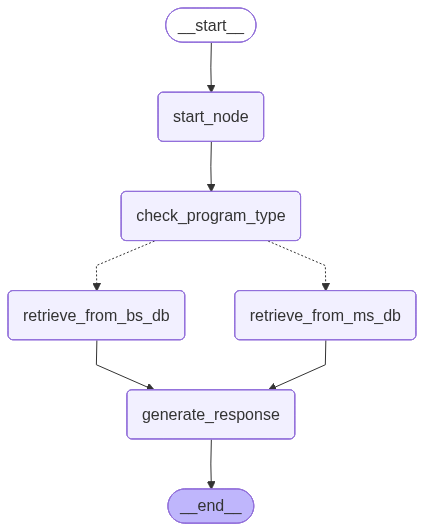

In [264]:
app

In [257]:
def ask(query: str):
    try:
        result = app.invoke({"query": query, "graph_info": ""})
        print("\n=== RAW RESULT STRUCTURE ===")
        print(result)
        print("============================\n")

        # Try all possible keys
        answer = (
            result.get("answer")
            or result.get("state", {}).get("answer")
            or result.get("state", {}).get("final_answer")
            or result.get("state", {}).get("output", {}).get("answer")
        )

        print("✅ Final Answer:", answer)
        return {"answer": answer, **result}

    except Exception as e:
        print("❌ Error during graph run:", e)
        return {"answer": "Error occurred.", "error": str(e)}


In [261]:
ask('Give a complete outline of Animal Diversity‑I')

[Start Node] start_node has been called.
[check_program_type] Received query: 'Give a complete outline of Animal Diversity‑I'
[check_program_type] Final program type: BS
route_program_type node has been called.
Detected program_type in state: BS
Routing decision: retrieve_from_bs_db
[BS Node] Running retrieval for query: 'Give a complete outline of Animal Diversity‑I'
[BS Node] Retrieved 10 raw docs from vector store.
[BS Node] Final 6 docs after hybrid ranking and cleaning.
   Doc 1 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf | Preview: Page 43 of 189 Course Title: Animal Diversity -II Course Code: ZOOL1116 Credit Hours: 3 (2+1) Pre -r...
   Doc 2 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf | Preview: Page 86 of 189 Course Title: Evolution and Principles of Systematics Course Code: ZOOL3125 Credit Ho...
   Doc 3 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf | Preview: Page 58 of 189 Course Title: Animal For

{'answer': "Sorry! I don't know.",
 'query': 'Give a complete outline of Animal Diversity‑I',
 'program_type': 'BS',
 'retrieved_docs': [Document(metadata={'program': 'MS', 'page': 42, 'source_path': '/home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf', 'moddate': '2024-08-07T15:24:13+05:00', 'creationdate': '2023-10-31T10:10:54+05:00', 'creator': 'Microsoft® Word 2010', 'page_label': '43', 'producer': 'Microsoft® Word 2010', 'char_count': 1726, 'section_type': 'course_outline', 'total_pages': 189, 'source': '/home/hammadali08/Downloads/CS/BS Data/BS Zoology (2023).pdf', 'source_file': 'BS Zoology (2023).pdf', 'author': 'abc', 'score': 0, 'hybrid_score': 0.2}, page_content='Page 43 of 189 Course Title: Animal Diversity -II Course Code: ZOOL1116 Credit Hours: 3 (2+1) Pre -requisite: F.Sc. Pre -Medical/A -Levels with Biology Objectives: The main objectives of this course are to: Provide understanding about taxonomic characteristics and classification of each phylum. Develop con

In [262]:
ask("What is the outline for Compiler Complition")

[Start Node] start_node has been called.
[check_program_type] Received query: 'What is the outline for Compiler Complition'
[check_program_type] Final program type: BS
route_program_type node has been called.
Detected program_type in state: BS
Routing decision: retrieve_from_bs_db
[BS Node] Running retrieval for query: 'What is the outline for Compiler Complition'
[BS Node] Retrieved 10 raw docs from vector store.
[BS Node] Final 6 docs after hybrid ranking and cleaning.
   Doc 1 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf | Preview: Page 33 Course Name: Compiler Construction Course Code: COMP3149 Credit Hours: 3 (2+1) Pre -requisit...
   Doc 2 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf | Preview: Page 20 Course Name: Computer Organization and Assembly Language Course Code: COMP2118 Credit Hours:...
   Doc 3 | Source: /home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf | Preview: Page 32 Course N

{'answer': "Sorry! I don't know.",
 'query': 'What is the outline for Compiler Complition',
 'program_type': 'BS',
 'retrieved_docs': [Document(metadata={'page': 32, 'source': '/home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf', 'source_file': 'BS Computer Science (2023).pdf', 'producer': 'Microsoft® Word 2010', 'program': 'MS', 'source_path': '/home/hammadali08/Downloads/CS/BS Data/BS Computer Science (2023).pdf', 'page_label': '33', 'course_code': 'COMP3149', 'section_type': 'course_outline', 'char_count': 2314, 'creator': 'Microsoft® Word 2010', 'author': 'MNA', 'creationdate': '2023-12-01T08:54:50+05:00', 'total_pages': 87, 'moddate': '2024-08-07T15:21:43+05:00', 'score': 0, 'hybrid_score': 0.25}, page_content='Page 33 Course Name: Compiler Construction Course Code: COMP3149 Credit Hours: 3 (2+1) Pre -requisites: Theory of Automata Course Introduction: Introduction, Lexical Analysis, Parsing, Syntax -Directed Translation, Type Checking, Intermediate Code Generat